In [1]:
import numpy as np
import cf
import os
import netCDF4
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import dates
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
plt.style.use('/home/ctroupin/.config/matplotlib/stylelib/darkocean.mplstyle')

In [2]:
figdir = "/home/ctroupin/Projects/2-National/201606_GlidingTurtes/figures"
basedir = "http://thredds.socib.es/thredds/dodsC/drifter/surface_drifter/"
drifterlist = ["drifter_odi023-scb_odi012/L1/2016/dep0002_drifter-odi023_scb-odi012_L1_2016-07-13.nc", 
               "drifter_odi024-scb_odi013/L1/2016/dep0002_drifter-odi024_scb-odi013_L1_2016-07-13.nc",
               "drifter_odi025-scb_odi014/L1/2016/dep0001_drifter-odi025_scb-odi014_L1_2016-07-13.nc"
              ]
drifterlist = [basedir + s for s in drifterlist]

In [3]:
cmap = plt.cm.RdYlBu_r
Nlon, Nlat = 5, 5

In [11]:
coordinates = [2.6, 2.85, 39.23, 39.4]
# coordinates = [np.floor(lon.min()), np.ceil(lon.max()), np.floor(lat.min()), np.ceil(lat.max())]
m = Basemap(projection='merc', llcrnrlon=coordinates[0], llcrnrlat=coordinates[2], urcrnrlon=coordinates[1],
            urcrnrlat=coordinates[3], lat_ts=0.5*(coordinates[2]+coordinates[3]), resolution='f')

Load all the data first, then make the plot.<br>
To avoid the drifters to be mixed, we put a NaN before the "append".<br>
Later: compute the coordinates of the region from the drifter positions.

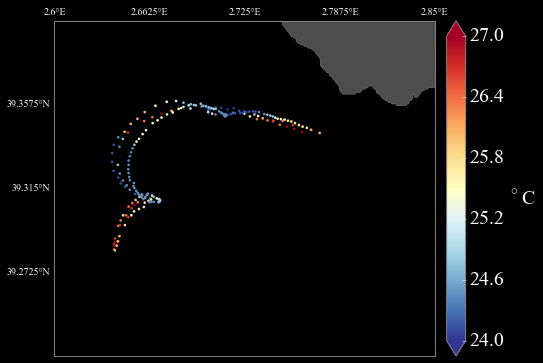

In [12]:
lon_all = np.array([])
lat_all = np.array([])
time_all = np.array([])
temperature_all = np.array([])

for datafile in drifterlist:
    lon, lat, time, temperature = ReadDrifterData(datafile)
    lon_all = np.append(lon_all, lon)
    lat_all = np.append(lat_all, lat)
    lon_all = np.append(lon_all, np.nan)
    lat_all = np.append(lat_all, np.nan)
    temperature_all = np.append(temperature_all, temperature)
    temperature_all = np.append(temperature_all, np.nan)
    
figname = os.path.join(figdir, 'GlidingTurtles_TemperatureDrifters')
PlotTemperatureDrifter(lon_all, lat_all, temperature_all, m, figname)


In [6]:
def ReadDrifterData(datafile):
    f = cf.read(datafile)
    temperature = f.select('sea_water_temperature')
    lon = temperature[0].coord('lon').array
    lat = temperature[0].coord('lat').array
    time = temperature[0].coord('time').array
    temperatureQC = temperature[0].ancillary_variables[0].array
    temperature = temperature[0].array
    cf.close_files()

    temperature = np.ma.masked_where(temperatureQC != 1, temperature)
    return lon, lat, time, temperature

In [7]:
def PlotTemperatureDrifter(lon, lat, temperature, m, figname):
    
    lon, lat = m(lon, lat)
    fig = plt.figure(figsize=(15, 6))
    
    fmin, fmax = np.ceil(np.nanmin(temperature_all)), np.floor(np.nanmax(temperature_all))
    norm = colors.Normalize(vmin=fmin, vmax=fmax)
    bounds = np.linspace(fmin, fmax, 6)

    ax = fig.add_subplot(111)
    scat = m.scatter(lon, lat, s=7, c=temperature, edgecolor='None', cmap=cmap, norm=norm)
    m.drawcoastlines(linewidth=0.3, color="0.7", zorder=3)
    m.drawcountries(linewidth=0.2, color="0.7", zorder=3)

    m.fillcontinents(color="0.3", zorder=2)
    m.drawparallels(np.linspace(coordinates[2], coordinates[3], Nlat), linewidth=0.,
                    labels=[1, 0, 0, 0], fontname='Times New Roman', zorder=1)
    m.drawmeridians(np.linspace(coordinates[0], coordinates[1], Nlon), linewidth=0.,
                    labels=[0, 0, 1, 0], fontname='Times New Roman', zorder=1)
    
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", "5%", pad="3%")

    cbar = plt.colorbar(scat, cax=cax, extend='both', cmap=cmap, norm=norm, orientation='vertical')
    cbar.set_ticks(bounds)
    cbar.set_label('$^{\circ}$C', rotation=0, ha='left')

    plt.savefig(figname, dpi=300, facecolor=fig.get_facecolor(), edgecolor='none')
    plt.show()
    plt.close()